In [1]:
import os
import numpy as np
import logging
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# 设置日志记录器
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

# 加载单个图像的函数（已修改以包含错误处理）
def load_image(img_id, rawdata_dir):
    img_path = os.path.join(rawdata_dir, f'{img_id}')
    try:
        with open(img_path, 'rb') as img_file:
            img_data = np.frombuffer(img_file.read(), dtype=np.uint8)
        if img_data.size == 16384:
            img_matrix = img_data.reshape((128, 128))
            return img_matrix
        else:
            # 记录错误信息并返回一个占位图像（例如，全黑图像）
            logging.error(f"Expected 16384 bytes for image {img_id}, but got {img_data.size}. Using a placeholder image.")
            placeholder_image = np.zeros((128, 128), dtype=np.uint8)
            return placeholder_image
    except Exception as e:
        # 记录无法读取文件时的错误信息并返回一个占位图像
        logging.error(f"Failed to load image {img_id} from {img_path}: {e}")
        placeholder_image = np.zeros((128, 128), dtype=np.uint8)
        return placeholder_image

# 读取数据的函数
def load_data(filepath, rawdata_dir):
    data = []
    labels = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            img_id = int(parts[0])
            gender = parts[1]
            age = parts[2]
            image = load_image(img_id, rawdata_dir)  # 使用 load_image 函数加载图像
            data.append(image.flatten())  # 展平为向量
            labels.append((gender, age))
    return np.array(data), labels

# 示例：加载数据
rawdata_dir = 'rawdata'  # 替换为您的原始数据目录路径
labels_filepath = 'cleared_faceDS.txt'  # 替换为您的标签文件路径
data, labels = load_data(labels_filepath, rawdata_dir)



In [2]:
# 加载训练和测试数据
train_data, train_labels = load_data('cleared_faceDR.txt', 'rawdata')
test_data, test_labels = load_data('cleared_faceDS.txt', 'rawdata')

# 数据归一化
def normalize_data(data):
    return (data / 255.0).astype(np.float32)
 
# 在加载数据后进行归一化
train_data = normalize_data(train_data)
test_data = normalize_data(test_data)

# 标签编码
gender_encoder = LabelEncoder()
age_encoder = LabelEncoder()
train_gender_labels = gender_encoder.fit_transform([label[0] for label in train_labels])
train_age_labels = age_encoder.fit_transform([label[1] for label in train_labels])
test_gender_labels = gender_encoder.transform([label[0] for label in test_labels])
test_age_labels = age_encoder.transform([label[1] for label in test_labels])

2025-01-09 17:44:57,519 - ERROR - Expected 16384 bytes for image 2412, but got 262144. Using a placeholder image.
2025-01-09 17:44:57,523 - ERROR - Expected 16384 bytes for image 2416, but got 262144. Using a placeholder image.


In [3]:
# 合并所有训练数据
X_train_all = np.array(train_data)

# PCA降维
n_components = 150  # 可以调整
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_all)
# 将测试数据也进行PCA降维
X_test_pca = pca.transform(test_data)

性别识别准确率: 0.68
年龄识别准确率: 0.34
性别识别损失率: 0.70
年龄识别损失率: 6.08

性别识别分类报告：
              precision    recall  f1-score   support

     (female       0.55      0.66      0.60       719
       (male       0.78      0.69      0.73      1277

    accuracy                           0.68      1996
   macro avg       0.67      0.68      0.67      1996
weighted avg       0.70      0.68      0.69      1996


年龄识别分类报告：
              precision    recall  f1-score   support

      adult)       0.83      0.35      0.49      1730
      child)       0.16      0.18      0.17        68
     senior)       0.20      0.39      0.27       115
       teen)       0.02      0.24      0.04        83

    accuracy                           0.34      1996
   macro avg       0.30      0.29      0.24      1996
weighted avg       0.74      0.34      0.45      1996



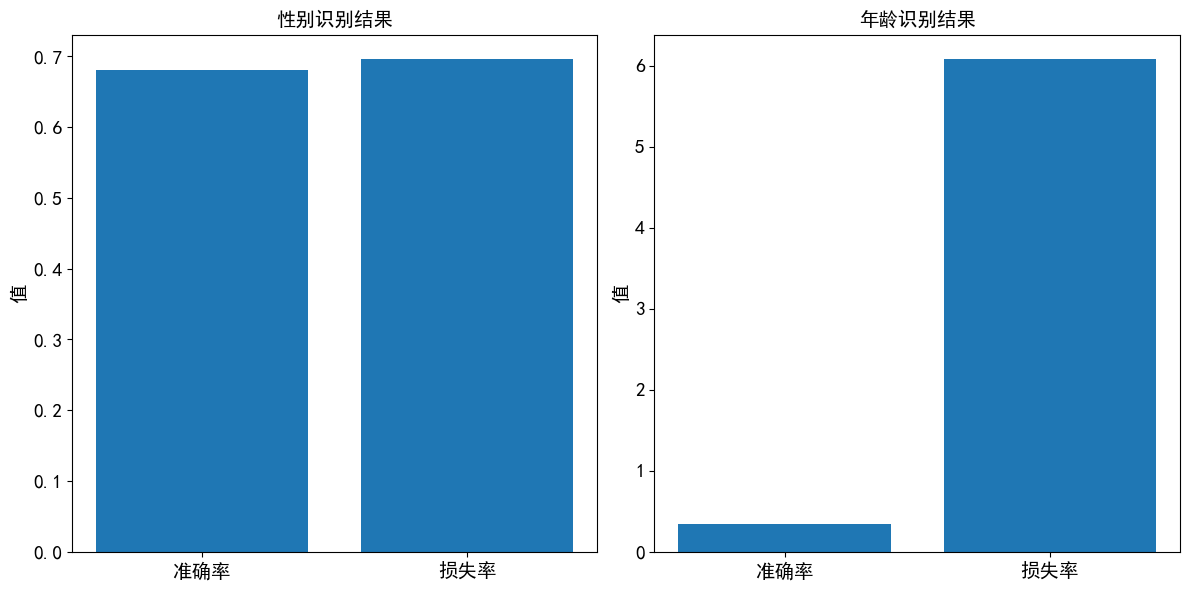

In [15]:
# 训练朴素贝叶斯模型
# 性别分类
nb_gender = GaussianNB(var_smoothing=1e-9)
nb_gender.fit(X_train_pca, train_gender_labels)

# 年龄分类
nb_age = GaussianNB(var_smoothing=1e-9)
nb_age.fit(X_train_pca, train_age_labels, sample_weight=[class_weights_dict[label] for label in train_age_labels])

# 预测
gender_pred = nb_gender.predict(X_test_pca)
age_pred = nb_age.predict(X_test_pca)

# 计算准确率
gender_accuracy = accuracy_score(test_gender_labels, gender_pred)
age_accuracy = accuracy_score(test_age_labels, age_pred)

# 计算损失率
gender_loss = log_loss(test_gender_labels, nb_gender.predict_proba(X_test_pca))
age_loss = log_loss(test_age_labels, nb_age.predict_proba(X_test_pca))

# 输出结果
print(f'性别识别准确率: {gender_accuracy:.2f}')
print(f'年龄识别准确率: {age_accuracy:.2f}')
print(f'性别识别损失率: {gender_loss:.2f}')
print(f'年龄识别损失率: {age_loss:.2f}')

# 生成分类报告
print("\n性别识别分类报告：")
print(classification_report(test_gender_labels, gender_pred, target_names=gender_encoder.classes_, zero_division=0))

print("\n年龄识别分类报告：")
print(classification_report(test_age_labels, age_pred, target_names=age_encoder.classes_, zero_division=0))

# 设置支持中文的字体
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=14)

# 可视化结果
plt.figure(figsize=(12, 6))

# 性别分类结果
plt.subplot(1, 2, 1)
plt.bar(['准确率', '损失率'], [gender_accuracy, gender_loss])
plt.title('性别识别结果', fontproperties=font)
plt.ylabel('值', fontproperties=font)
plt.xticks(fontproperties=font)  # 设置 x 轴标签字体
plt.yticks(fontproperties=font)  # 设置 y 轴标签字体

# 年龄分类结果
plt.subplot(1, 2, 2)
plt.bar(['准确率', '损失率'], [age_accuracy, age_loss])
plt.title('年龄识别结果', fontproperties=font)
plt.ylabel('值', fontproperties=font)
plt.xticks(fontproperties=font)  # 设置 x 轴标签字体
plt.yticks(fontproperties=font)  # 设置 y 轴标签字体

plt.tight_layout()
plt.show()